# Primera parte - preparación del dataset

### Como primera parte vamos a importar el dataset que tenemos guardado localmente en un CSV (obtenido mediante ETL usando un DAG de airflow). Una vez importado determinaremos un flag de abandono. Este flag de abandono se coloca a cada cliente en caso de que la fecha de su ultima compra sea mayor a los 90 dias desde una fecha de referencia para el analisis. Con este flag, armamos una tabla de clientes que abandonaron y luego mostramos los datos de los clientes con esta situación.

#### Importamos el archivo, verificamos la cantidad de filas y el contenido de las primeras

In [2]:
from tabulate import tabulate
import pandas as pd
import numpy as np

# Cargar dataset
df = pd.read_csv("ventas_2025-10-02.csv", parse_dates=["CreadoEl"], dayfirst=True, dtype={"Cliente": "Int64"})

# Convertir columna ValorNeto a numérico
def to_float_ars(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    s = s.replace(".", "")          
    s = s.replace(",", ".")          
    s = s.replace("$", "").replace("ARS", "").strip()
    try:
        return float(s)
    except:
        return np.nan

df["ValorNeto_num"] = df["ValorNeto"].apply(to_float_ars)

# Armar tabla de clientes
clientes = (
    df.groupby("Cliente")
      .agg(
          ultima_compra=("CreadoEl", "max"),
          primera_compra=("CreadoEl", "min"),
          cantidad_pedidos=("Documento", "count"),
          gasto_total=("ValorNeto_num", "sum"),
          ticket_promedio=("ValorNeto_num", "mean")
      )
      .reset_index()
)

extra_cols = ["Nombre1", "Nombre2", "Localidad", "CodPostal", "Calle", "CUIT"]
clientes = clientes.merge(
    df[["Cliente"] + extra_cols].drop_duplicates("Cliente"),
    on="Cliente",
    how="left"
)

# Usamos la fecha de la última compra de cada cliente como fecha de referencia
fecha_actual = pd.to_datetime("2025-10-02").normalize()  
clientes["recency_dias"] = (fecha_actual - clientes["ultima_compra"]).dt.days

# Definición del objetivo: abandono = >90 días sin comprar
UMBRAL_ABANDONO = 90
clientes["abandono_flag"] = (clientes["recency_dias"] > UMBRAL_ABANDONO).astype(int)

# Formatear fechas para que se muestren como texto en formato dd-mm-YYYY
clientes["ultima_compra"] = clientes["ultima_compra"].dt.strftime("%d-%m-%Y")
clientes["primera_compra"] = clientes["primera_compra"].dt.strftime("%d-%m-%Y")

# Función para formatear el gasto en ARS
def format_ars(x):
    if pd.isna(x):
        return ""
    return f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

# Aplicar formato a los gastos
clientes["gasto_total"] = clientes["gasto_total"].apply(format_ars)
clientes["ticket_promedio"] = clientes["ticket_promedio"].apply(format_ars)

# Mostrar resultados
print("Cantidad de filas del dataset:", len(df))
print("\nMostrar primeros clientes:\n")
print(tabulate(clientes.head(20), headers="keys", tablefmt="pretty"))


/var/folders/y0/404pxmfn357ftb9snt8c2x4r0000gn/T/ipykernel_631/2804708804.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("ventas_2025-10-02.csv", parse_dates=["CreadoEl"], dayfirst=True, dtype={"Cliente": "Int64"})


Cantidad de filas del dataset: 1814892

Mostrar primeros clientes:

+----+---------+---------------+----------------+------------------+------------------+-----------------+-------------------------------------+----------------------------+---------------+-----------+----------------------------------+-------------+--------------+---------------+
|    | Cliente | ultima_compra | primera_compra | cantidad_pedidos |   gasto_total    | ticket_promedio |               Nombre1               |          Nombre2           |   Localidad   | CodPostal |              Calle               |    CUIT     | recency_dias | abandono_flag |
+----+---------+---------------+----------------+------------------+------------------+-----------------+-------------------------------------+----------------------------+---------------+-----------+----------------------------------+-------------+--------------+---------------+
| 0  |    5    |  30-09-2025   |   03-01-2024   |       1817       | 1.403.818.851,11 |  

#### Ahora filtramos los clientes que cumplen la condición de abandono y sus datos

In [3]:

# Mostramos todos los clientes que cumplen la condición de abandono

abandono_clientes = clientes[clientes["abandono_flag"] == 1]

# Cantidad de clientes que cumplen la condición
cantidad_clientes = abandono_clientes.shape[0]

# Mostrar resumen con formato
print("="*50)
print(f" Clientes con condición de abandono (> {UMBRAL_ABANDONO} días sin comprar)")
print(f" Cantidad total: {cantidad_clientes}")
print("="*50)

# Mostrar primeros 20
from tabulate import tabulate
print(tabulate(abandono_clientes.head(20), headers='keys', tablefmt='pretty'))


 Clientes con condición de abandono (> 90 días sin comprar)
 Cantidad total: 104
+-----+---------+---------------+----------------+------------------+----------------+-----------------+-------------------------------------+-------------------------------+------------------+-----------+----------------------------------+-------------+--------------+---------------+
|     | Cliente | ultima_compra | primera_compra | cantidad_pedidos |  gasto_total   | ticket_promedio |               Nombre1               |            Nombre2            |    Localidad     | CodPostal |              Calle               |    CUIT     | recency_dias | abandono_flag |
+-----+---------+---------------+----------------+------------------+----------------+-----------------+-------------------------------------+-------------------------------+------------------+-----------+----------------------------------+-------------+--------------+---------------+
|  7  |   30    |  06-02-2025   |   02-01-2024   |       577 

# Segunda parte - Formulación de hipotesis


### Hipotesis 1: Hay clientes que a pesar de gastar mucho, muestran abandono (por ejemplo insatisfaccion, consiguen otro vendedor, etc)

### Objetivo: detectar clientes que gastan mucho y abandonan, es decir gasto_total alto pero abandono_flag = 1.

#### Buscamos los clientes que abandonaron y gastaron más de un umbral que establecimos de 1 millón de pesos

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir gasto_total a numérico si está formateado como texto
clientes['gasto_total_num'] = (
    clientes['gasto_total']
        .astype(str)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False)
        .astype(float)
)

outliers_abandono = clientes[
    (clientes['gasto_total_num'] > 1_000_000) & 
    (clientes['abandono_flag'] == 1)
]

print(f"Clientes de alto gasto que abandonaron: {len(outliers_abandono)}")
display(outliers_abandono[['Cliente', 'gasto_total_num', 'cantidad_pedidos', 'recency_dias', 'ticket_promedio', 'abandono_flag']])


Clientes de alto gasto que abandonaron: 19


,Cliente,gasto_total_num,cantidad_pedidos,recency_dias,ticket_promedio,abandono_flag
7,30,1.015943e+08,577,238,"176.073,38",1
69,335,1.976959e+06,42,331,"47.070,46",1
128,482,7.680107e+07,490,126,"156.736,87",1
270,1810,1.329370e+08,3500,169,"37.981,99",1
493,2740,1.153656e+06,50,602,"23.073,11",1
523,2837,7.593205e+07,6,476,"12.655.342,16",1
551,2959,1.127775e+06,29,195,"38.888,79",1
593,3136,1.813747e+07,550,240,"32.977,22",1
660,3367,5.018771e+06,108,346,"46.470,10",1
679,3393,5.106450e+07,811,330,"62.964,85",1


#### Encontramos que de 47 clientes que tenian la condición de abono, solamente 11 clientes tienen un gasto alto (mas de un millón de pesos) e igual abandonaron. En función de estos resultados nos interesa saber cuales son los tipos de pedido que más realizaron estos clientes y que vendedores los atendieron.

Total de ventas realizadas a estos clientes: 7196
Top vendedores con más pedidos a clientes que abandonaron:


,Vendedor,CantidadVentas
0,GUILLERMO GUEVARA,4346
3,JUAN DE ANGELI,1623
5,SEBASTIAN DI CESARE,665
2,Grupo vendedores SJN,461
4,PELAYES SERGIO,66
1,Grupo vendedores MDZ,35



Tipos de pedido más frecuentes en esos clientes:


,ClaseVenta,DenominacionClase,CantidadVentas
2,ZTP,Pedido Venta Portal,6887
3,ZTR,Pedido Transfers,185
0,ZLIC,Ped. Licitación,72
1,ZPEM,Pedido Empleados,35
4,ZTVE,Pedido Vendedores,17


/var/folders/y0/404pxmfn357ftb9snt8c2x4r0000gn/T/ipykernel_631/2185421675.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


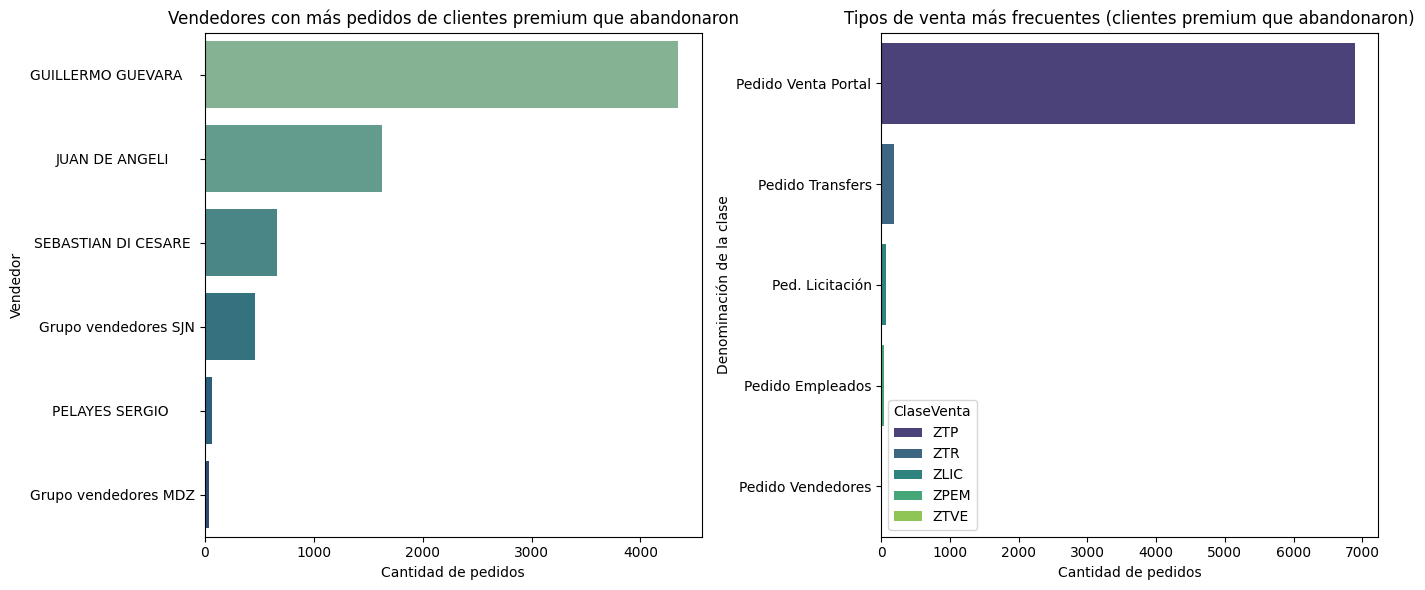

El vendedor con más pedidos de clientes premium que abandonaron fue GUILLERMO GUEVARA   .
El tipo de pedido más común fue Pedido Venta Portal.


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

clientes_abandono_ids = outliers_abandono["Cliente"].unique()
compras_abandono = df[df["Cliente"].isin(clientes_abandono_ids)].copy()

print(f"Total de ventas realizadas a estos clientes: {len(compras_abandono)}")

# Agrupar por vendedor
ventas_por_vendedor = (
    compras_abandono
    .groupby("Vendedor")
    .size()
    .reset_index(name="CantidadVentas")
    .sort_values("CantidadVentas", ascending=False)
)

# Agrupar por clase de venta
ventas_por_clase = (
    compras_abandono
    .groupby(["ClaseVenta", "DenominacionClase"])
    .size()
    .reset_index(name="CantidadVentas")
    .sort_values("CantidadVentas", ascending=False)
)

# Mostrar resultados
print("Top vendedores con más pedidos a clientes que abandonaron:")
display(ventas_por_vendedor.head(10))

print("\nTipos de pedido más frecuentes en esos clientes:")
display(ventas_por_clase.head(10))

# Gráfico combinado de vendedores y clases
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Vendedores con más pedidos
sns.barplot(
    data=ventas_por_vendedor.head(10),
    x="CantidadVentas",
    y="Vendedor",
    palette="crest",
    ax=axes[0]
)
axes[0].set_title("Vendedores con más pedidos de clientes premium que abandonaron")
axes[0].set_xlabel("Cantidad de pedidos")
axes[0].set_ylabel("Vendedor")

# Tipos de venta más frecuentes
sns.barplot(
    data=ventas_por_clase.head(10),
    x="CantidadVentas",
    y="DenominacionClase",
    hue="ClaseVenta",
    dodge=False,
    palette="viridis",
    ax=axes[1]
)
axes[1].set_title("Tipos de venta más frecuentes (clientes premium que abandonaron)")
axes[1].set_xlabel("Cantidad de pedidos")
axes[1].set_ylabel("Denominación de la clase")
axes[1].legend(title="ClaseVenta")

plt.tight_layout()
plt.show()

# Resumen 
top_vendedor = ventas_por_vendedor.iloc[0]["Vendedor"] if len(ventas_por_vendedor) > 0 else "N/A"
top_clase = ventas_por_clase.iloc[0]["DenominacionClase"] if len(ventas_por_clase) > 0 else "N/A"
print(f"El vendedor con más pedidos de clientes premium que abandonaron fue {top_vendedor}.")
print(f"El tipo de pedido más común fue {top_clase}.")


#### Conclusión hipotesis: como conclusión podriamos decir que no son muchos los clientes que tienen un gasto alto y han presentado abandono, se verifica que son 11 de 47 clientes (un 23% aproximadamente). También estos resultados nos permitió darnos cuenta que el tipo de pedido más frecuente realizado por los clientes que abandonaron fue "Pedido venta portal web", por lo que habría que reforzar estrategias de venta de ecommerce. Además pudimos verificar que el vendedor que más atendió a estos clientes fue Guillermo Guevara, por lo tanto se deberían tomar ciertas medidas correctivas a su trabajo.


### Hipotesis 2: Los clientes cuya primera compra fue a principios de año tienen más chances de abandonar (clientes “curiosos” que no se fidelizaron)

### Objetivo: detectar si el mes influye en el abandono para reforzar técnicas de venta y hacer que los clientes sigan comprando el resto de los meses.

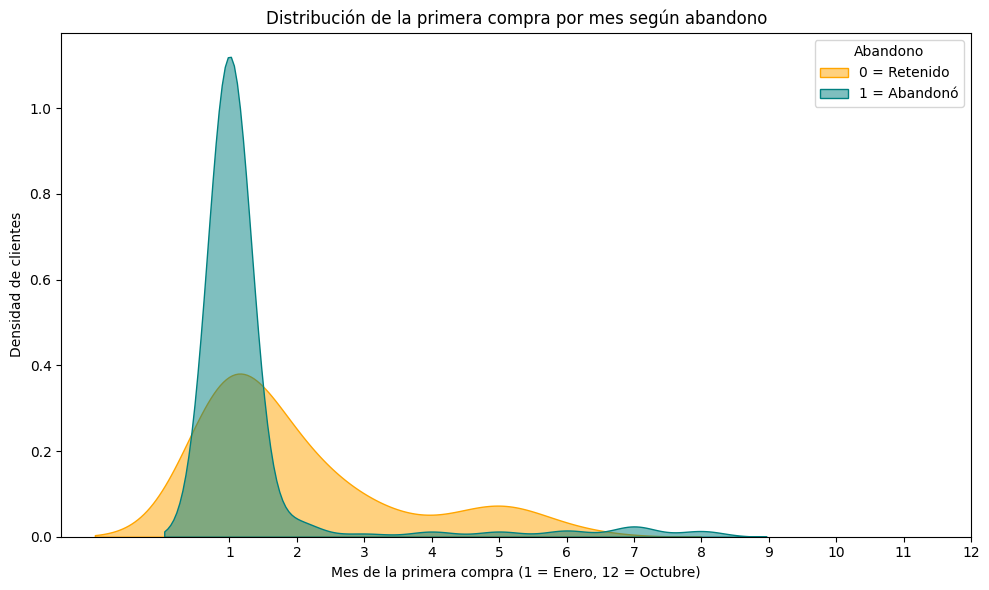

abandono_flag,0,1
mes_primera_compra,,
1,940.0,26.0
2,28.0,10.0
3,6.0,4.0
4,10.0,1.0
5,10.0,5.0
6,12.0,1.0
7,20.0,0.0
8,11.0,0.0


Aproximadamente el 85.1% de los clientes que abandonaron realizaron su primera compra en el primer trimestre del año.


In [7]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Si 'primera_compra' está como texto (por ejemplo 'dd-mm-YYYY'), la convertimos:
clientes["primera_compra_dt"] = pd.to_datetime(clientes["primera_compra"], errors="coerce", dayfirst=True)

# Extraer mes de la primera compra 
clientes["mes_primera_compra"] = clientes["primera_compra_dt"].dt.month

# Calcular cuántos clientes hay por mes y abandono 
conteo_mes = (
    clientes
    .groupby(["mes_primera_compra", "abandono_flag"])
    .size()
    .reset_index(name="CantidadClientes")
)

# Gráfico de densidad (distribución temporal de primera compra)
plt.figure(figsize=(10,6))
sns.kdeplot(
    data=clientes.dropna(subset=["mes_primera_compra"]),
    x="mes_primera_compra",
    hue="abandono_flag",
    fill=True,
    common_norm=False,
    palette={0: "teal", 1: "orange"},
    alpha=0.5
)

plt.title("Distribución de la primera compra por mes según abandono")
plt.xlabel("Mes de la primera compra (1 = Enero, 12 = Octubre)")
plt.ylabel("Densidad de clientes")
plt.xticks(range(1,13))
plt.legend(title="Abandono", labels=["0 = Retenido", "1 = Abandonó"])
plt.tight_layout()
plt.show()


display(conteo_mes.pivot(index="mes_primera_compra", columns="abandono_flag", values="CantidadClientes").fillna(0))

# Resultados automáticos
abandono_inicio = conteo_mes.loc[(conteo_mes["mes_primera_compra"] <= 3) & (conteo_mes["abandono_flag"] == 1), "CantidadClientes"].sum()
abandono_total = conteo_mes.loc[conteo_mes["abandono_flag"] == 1, "CantidadClientes"].sum()

if abandono_total > 0:
    pct_abandono_inicio = (abandono_inicio / abandono_total) * 100
    print(f"Aproximadamente el {pct_abandono_inicio:.1f}% de los clientes que abandonaron realizaron su primera compra en el primer trimestre del año.")
else:
    print("No hay clientes marcados como abandono para calcular proporciones.")


#### Se observa una mayor concentración de clientes abandonadores cuya primera compra ocurrió en los primeros meses del año. Esto respalda la hipótesis de que muchos de los clientes que compraron en enero o febrero fueron “curiosos” o de baja fidelización. Los resultados muestran que la gran mayoría de los clientes que abandonaron realizaron su primera compra durante el primer trimestre del año (principalmente en enero).

,VendedorAlta,clientes_enero,abandonaron,tasa_abandono
4,PELAYES SERGIO,10,3,0.300000
1,Grupo vendedores MDZ,121,13,0.107438
2,Grupo vendedores SJN,45,3,0.066667
3,JUAN DE ANGELI,263,3,0.011407
0,GUILLERMO GUEVARA,191,2,0.010471
5,SEBASTIAN DI CESARE,242,2,0.008264
6,SERGIO RIDOLFI,94,0,0.000000


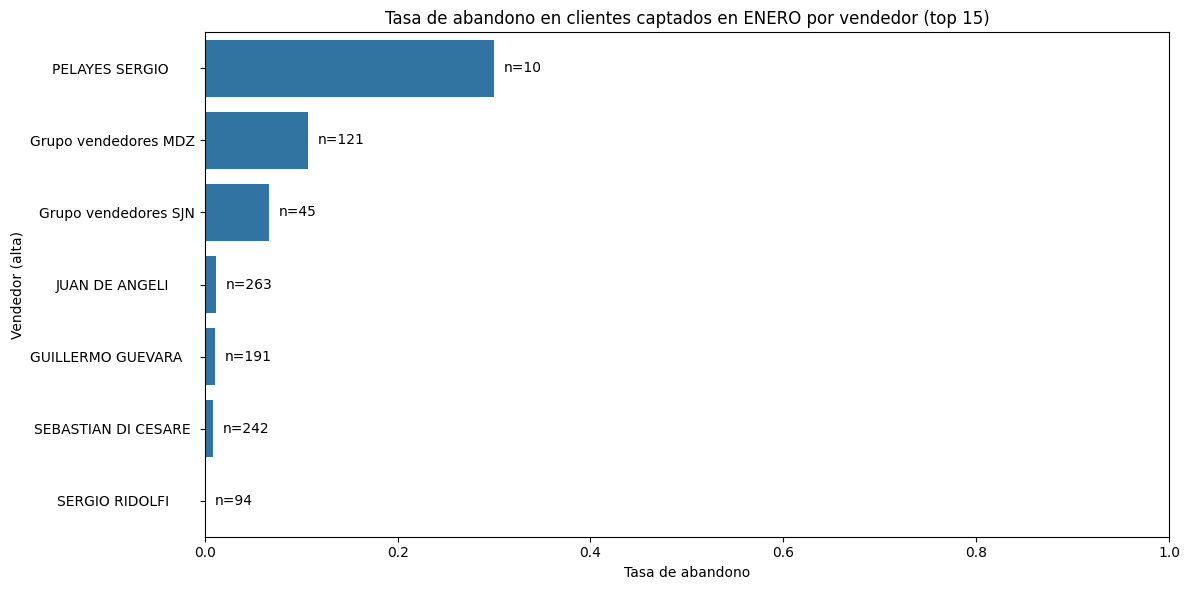

In [ ]:

df["CreadoEl"] = pd.to_datetime(df["CreadoEl"], errors="coerce", dayfirst=True)


first_rows_idx = df.sort_values("CreadoEl").groupby("Cliente", as_index=False).head(1).set_index("Cliente")
vendedor_alta = first_rows_idx["Vendedor"].rename("VendedorAlta")

# Clientes cuya primera compra fue en ENERO (mes=1)

clientes_enero = clientes.loc[clientes["mes_primera_compra"] == 1, ["Cliente", "abandono_flag"]].copy()


clientes_enero = clientes_enero.join(vendedor_alta, on="Cliente")


clientes_enero = clientes_enero.dropna(subset=["VendedorAlta"])


tasa_por_vendedor = (
    clientes_enero
    .groupby("VendedorAlta", as_index=False)
    .agg(
        clientes_enero=("Cliente", "nunique"),
        abandonaron=("abandono_flag", "sum"),
        tasa_abandono=("abandono_flag", "mean"),
    )
    .sort_values(["tasa_abandono", "clientes_enero"], ascending=[False, False])
)

display(tasa_por_vendedor.head(15))

# Gráfico de tasa de abandono de clientes captados en enero por vendedor
plt.figure(figsize=(12,6))
sns.barplot(
    data=tasa_por_vendedor.head(15),
    x="tasa_abandono",
    y="VendedorAlta",
)
plt.title("Tasa de abandono en clientes captados en ENERO por vendedor (top 15)")
plt.xlabel("Tasa de abandono")
plt.ylabel("Vendedor (alta)")

for i, (rate, n) in enumerate(zip(tasa_por_vendedor.head(15)["tasa_abandono"],
                                  tasa_por_vendedor.head(15)["clientes_enero"])):
    plt.text(rate + 0.01, i, f"n={int(n)}", va="center")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()



#### Conclusión: podemos afirmar que entre los clientes que abandonaron, la mayoría realizó su primera compra en enero o febrero por lo tanto, podemos decir que fueron clientes que no se fidelizaron. Esto nos ayudaría a reforzar el negocio aplicando tecnicas para que los clientes permanezcan durante todo el año. También pudimos notar que a principios de año, uno de los vendedores tuvo una tasa de abandono elevada por lo tanto deberíamos analizar que pudo suceder estos meses con este vendedor

### Hipotesis 3: Los clientes con compras muy dispersas en el tiempo tienden a abandonar.

### Objetivo: evaluar el comportamiento temporal del cliente, suponiendo que los clientes con compras más irregulares (mayor dispersión en el tiempo) tienden a abandonar. Vamos a calcular la varianza de los días entre compras por cliente, y luego analizar su relación con abandono_flag

Dispersión de días entre compras (por abandono_flag):


,count,mean,std,min,25%,50%,75%,max
abandono_flag,,,,,,,,
0,1037.0,4.238793,8.793468,0.0,0.560007,0.850180,3.076966,108.187338
1,47.0,11.108816,13.471551,0.0,0.000000,8.485281,14.565183,49.742671


/var/folders/y0/404pxmfn357ftb9snt8c2x4r0000gn/T/ipykernel_56764/2918181219.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


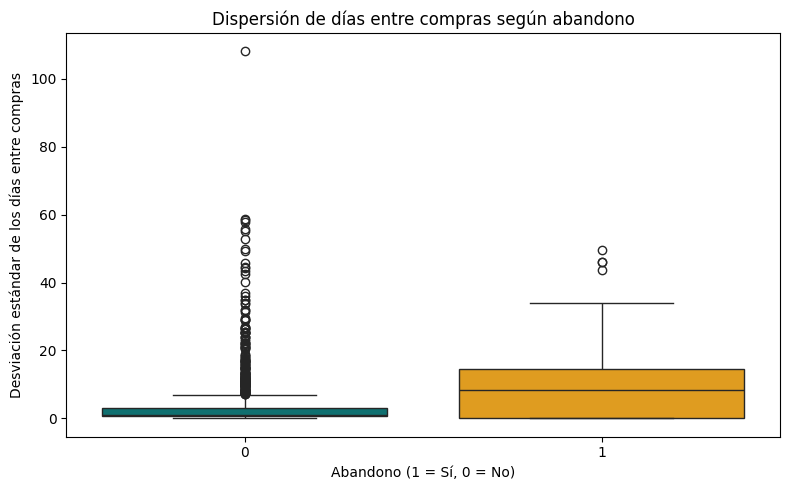

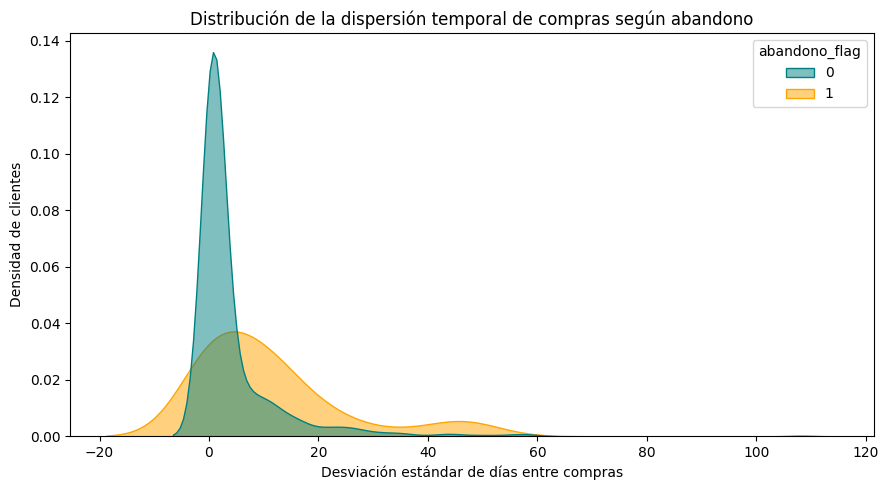

Los clientes que abandonaron tienen en promedio una dispersión mayor (6.9 días de diferencia) en los intervalos entre compras que los retenidos.


In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df["CreadoEl"] = pd.to_datetime(df["CreadoEl"], errors="coerce", dayfirst=True)

# Calcular diferencias de días entre compras para cada cliente 
df_sorted = df.sort_values(["Cliente", "CreadoEl"])
df_sorted["diff_dias"] = df_sorted.groupby("Cliente")["CreadoEl"].diff().dt.days


dispersion_compras = (
    df_sorted.groupby("Cliente")["diff_dias"]
    .agg(["mean", "std", "count"])
    .rename(columns={"mean": "promedio_dias", "std": "dispersion_dias", "count": "num_dif"})
    .reset_index()
)


clientes_dispersion = clientes.merge(dispersion_compras, on="Cliente", how="left")


clientes_dispersion["dispersion_dias"] = clientes_dispersion["dispersion_dias"].fillna(0)


resumen = clientes_dispersion.groupby("abandono_flag")["dispersion_dias"].describe()
print("Dispersión de días entre compras (por abandono_flag):")
display(resumen)

# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(
    data=clientes_dispersion,
    x="abandono_flag",
    y="dispersion_dias",
    palette=["teal", "orange"]  
)
plt.title("Dispersión de días entre compras según abandono")
plt.xlabel("Abandono (1 = Sí, 0 = No)")
plt.ylabel("Desviación estándar de los días entre compras")
plt.tight_layout()
plt.show()

# Densidad
plt.figure(figsize=(9,5))
sns.kdeplot(
    data=clientes_dispersion,
    x="dispersion_dias",
    hue="abandono_flag",
    fill=True,
    common_norm=False,
    palette={0: "teal", 1: "orange"},
    alpha=0.5
)
plt.title("Distribución de la dispersión temporal de compras según abandono")
plt.xlabel("Desviación estándar de días entre compras")
plt.ylabel("Densidad de clientes")
plt.tight_layout()
plt.show()

# Mostrar resultados
mean_abandon = clientes_dispersion.loc[clientes_dispersion["abandono_flag"]==1, "dispersion_dias"].mean()
mean_retenidos = clientes_dispersion.loc[clientes_dispersion["abandono_flag"]==0, "dispersion_dias"].mean()
dif = mean_abandon - mean_retenidos
tendencia = "mayor" if dif > 0 else "menor"
print(f"Los clientes que abandonaron tienen en promedio una dispersión {tendencia} ({abs(dif):.1f} días de diferencia) en los intervalos entre compras que los retenidos.")


#### Conclusión: Los resultados muestran que los clientes que abandonaron presentan una mayor dispersión temporal en sus compras es decir, compran de manera más irregular y con lapsos más largos entre compras. Además los graficos nos permitieron determinar que, los clientes retenidos tienen una dispersión baja (hacen compras cada 0-3 días) lo cual significa una frecuencia de compra estable y los clientes que abandonaron tienen dispersión más alta, con una mediana alrededor de 10–15 días y algunos casos extremos hasta 50 días, lo cual refleja mayor irregularidad o compras esporadicas.

#### De todas formas lo curioso es que hay casos extremos de clientes que no abandonaron pero que tienen una dispersión de hasta casi 60 días, lo cual resulta extraño pero se debería analizar que pasó durante ese periodo de tiempo que los clientes no compraron. 

### Hipotesis 4: Los clientes de localidades más alejadas a la localidad de la empresa (Maipú) tienen mayor tasa de abadono.

### Objetivo: el objetivo es evaluar si clientes con las localidades más alejadas a la localidad en donde se encuentra la empresa, tienen mayor tasa de abandono, por lo tanto, son mas propensos a abandonar (por diversos factores como demora en entregas, tiempos de espera muy altos, etc.)

Localidades con al menos 1 abandono: 25
Abandonos totales en estas localidades: 47


,Localidad,clientes,abandonaron,tasa_abandono,pct_de_los_abandonos
32,CRUZ DE PIEDRA,1,1,1.000000,0.021277
2,AGRELO,2,1,0.500000,0.021277
70,MEDIA AGUA,4,1,0.250000,0.021277
29,COQUIMBITO,5,1,0.200000,0.021277
40,EUGENIO BUSTOS,5,1,0.200000,0.021277
105,TUNUYAN,14,2,0.142857,0.042553
46,GUTIERREZ,7,1,0.142857,0.021277
49,JUNIN,7,1,0.142857,0.021277
106,TUPUNGATO,9,1,0.111111,0.021277
64,LUZURIAGA,10,1,0.100000,0.021277


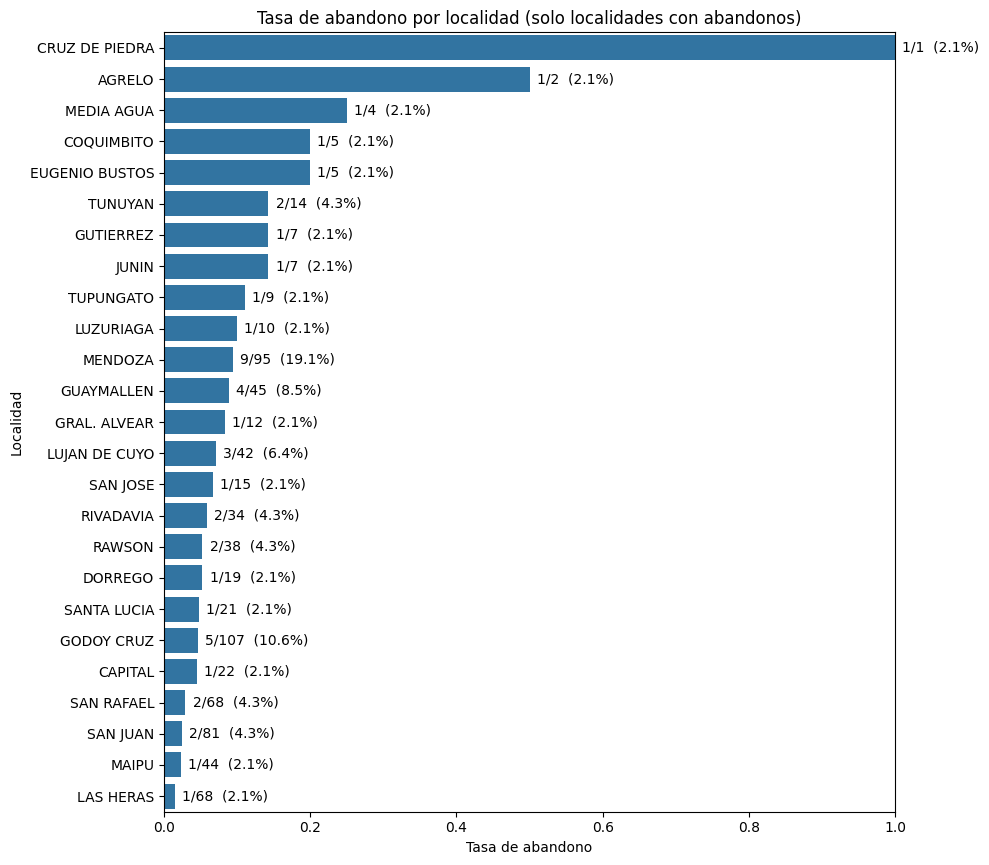

In [ ]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata

ONLY_MENDOZA = False     
MIN_CLIENTES = 1         
CANDIDATOS_LOCALIDAD = ["Localidad", "localidad", "Zona", "zona", "LocalidadCliente"]


col_loc = next((c for c in CANDIDATOS_LOCALIDAD if c in df.columns), None)
if not col_loc:
    raise ValueError(f"No hay columna de localidad en df. {CANDIDATOS_LOCALIDAD}")

# Normalizador (evita duplicados)
def normalizar(s):
    if pd.isna(s): 
        return s
    s = str(s).strip()
    s = "".join(ch for ch in unicodedata.normalize("NFKD", s) if not unicodedata.combining(ch))
    return s.upper()


localidad_cliente = (
    df.groupby("Cliente")[col_loc]
      .agg(lambda s: s.mode().iloc[0] if len(s.mode()) else s.iloc[0])
      .reset_index()
      .rename(columns={col_loc: "Localidad_raw"})
)
localidad_cliente["Localidad_norm"] = localidad_cliente["Localidad_raw"].apply(normalizar)


def asignar_provincia(loc):
    if pd.isna(loc): 
        return None
    if loc in {"RAWSON", "SANTA LUCIA", "SANTA LUCÍA"}:
        return "SAN JUAN"
    return "MENDOZA"

localidad_cliente["Provincia"] = localidad_cliente["Localidad_norm"].apply(asignar_provincia)


cli_loc = clientes.merge(
    localidad_cliente[["Cliente", "Localidad_norm", "Provincia"]],
    on="Cliente", how="left"
)


if ONLY_MENDOZA:
    cli_loc = cli_loc[cli_loc["Provincia"] == "MENDOZA"].copy()

abandono_por_loc = (
    cli_loc.groupby(["Localidad_norm"], dropna=False)
           .agg(clientes=("Cliente", "nunique"),
                abandonaron=("abandono_flag", "sum"))
           .reset_index()
           .rename(columns={"Localidad_norm": "Localidad"})
)
abandono_por_loc["tasa_abandono"] = abandono_por_loc["abandonaron"] / abandono_por_loc["clientes"]

# Localidades con abandono
abandono_con_aband = (abandono_por_loc
                      .query("abandonaron >= 1 and clientes >= @MIN_CLIENTES")
                      .sort_values(["tasa_abandono", "abandonaron", "clientes"],
                                   ascending=[False, False, False]))


total_aband = abandono_con_aband["abandonaron"].sum()
abandono_con_aband["pct_de_los_abandonos"] = abandono_con_aband["abandonaron"] / total_aband

print(f"Localidades con al menos 1 abandono: {len(abandono_con_aband)}")
print(f"Abandonos totales en estas localidades: {int(total_aband)}")
display(abandono_con_aband)

# 9) Gráfico de barras de tasa de abandono por localidad
plt.figure(figsize=(10, max(5, 0.35 * len(abandono_con_aband))))
sns.barplot(
    data=abandono_con_aband,
    x="tasa_abandono",
    y="Localidad",
)
plt.title("Tasa de abandono por localidad (solo localidades con abandonos)")
plt.xlabel("Tasa de abandono")
plt.ylabel("Localidad")

for i, (rate, n_ab, n_tot, pct) in enumerate(zip(
        abandono_con_aband["tasa_abandono"],
        abandono_con_aband["abandonaron"],
        abandono_con_aband["clientes"],
        abandono_con_aband["pct_de_los_abandonos"])):
    plt.text(rate + 0.01, i, f"{n_ab}/{n_tot}  ({pct:.1%})", va="center")

plt.xlim(0, 1)
plt.tight_layout()
plt.show()


#### Ahora vamos a marcar las localidades en un mapa de Argentina y su distancia a la empresa (con Localida en Maipú). Marcaremos con un punto rojo las localidades en donde abandonaron más de un cliente.

In [ ]:
import folium
import numpy as np
import pandas as pd
import math


df_candidates = []
for name in ["abandono_con_aband", "abandono_filtrado", "abandono_por_loc"]:
    if name in globals():
        df_candidates.append(globals()[name])
if not df_candidates:
    raise ValueError("No encontré ninguno de estos DF: abandono_con_aband / abandono_filtrado / abandono_por_loc")
df_plot = df_candidates[0].copy()
df_plot["Localidad"] = df_plot["Localidad"].astype(str).str.upper()

# Mapeo de coordenadas
coords = {
    "CRUZ DE PIEDRA": (-33.0311, -68.7761),
    "AGRELO": (-33.1181, -68.8869),
    "MEDIA AGUA": (-31.983333, -68.433333),
    "COQUIMBITO": (-32.966667, -68.75),
    "EUGENIO BUSTOS": (-33.778056, -69.065),
    "TUNUYAN": (-33.566667, -69.016667),
    "GUTIERREZ": (-32.9667, -68.75),
    "JUNIN": (-33.25, -68.716667),
    "TUPUNGATO": (-33.3728, -69.1475),
    "LUZURIAGA": (-32.9431, -68.7939),
    "MENDOZA": (-32.889722222222, -68.84444444444),
    "GUAYMALLEN": (-32.9053, -68.7867),
    "GRAL. ALVEAR": (-34.966666666667, -67.7),
    "LUJAN DE CUYO": (-33.016666666667, -68.866666666667),
    "SAN JOSE": (-32.8897, -68.825),
    "RIVADAVIA": (-33.1833, -68.4667),
    "RAWSON": (-31.56, -68.5589),
    "DORREGO": (-32.8969, -68.8311),
    "SANTA LUCIA": (-31.5406, -68.4989),
    "GODOY CRUZ": (-32.9330, -68.8450),
    "CAPITAL": (-32.916666666667, -68.833333333333),
    "SAN RAFAEL": (-34.6175, -68.335555555556),
    "SAN JUAN": (-31.53726, -68.52568),
    "MAIPU": (-32.966666666667, -68.75),
    "LAS HERAS": (-32.85, -68.816666666667),
}


plot_map = df_plot[df_plot["Localidad"].isin(coords.keys())].copy()
plot_map["Latitud"]  = plot_map["Localidad"].map(lambda x: coords[x][0])
plot_map["Longitud"] = plot_map["Localidad"].map(lambda x: coords[x][1])

if plot_map.empty:
    raise ValueError("Ninguna localidad del DF coincide con las del diccionario de coordenadas.")


def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    φ1, λ1, φ2, λ2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dφ = φ2 - φ1
    dλ = λ2 - λ1
    a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

if "MAIPU" not in coords:
    raise ValueError("No encuentro MAIPU en el diccionario de coordenadas.")
maipu_lat, maipu_lon = coords["MAIPU"]

# Distancia desde Maipú para cada punto
plot_map["dist_km_maipu"] = plot_map.apply(
    lambda r: haversine_km(maipu_lat, maipu_lon, r["Latitud"], r["Longitud"]), axis=1
)

# Crear mapa
center_lat = float(plot_map["Latitud"].mean())
center_lon = float(plot_map["Longitud"].mean())
m = folium.Map(location=[center_lat, center_lon], zoom_start=7, tiles="CartoDB positron")

# Marcador de Maipú
folium.Marker(
    location=[maipu_lat, maipu_lon],
    popup="<b>MAIPU (origen)</b>",
    icon=folium.Icon(color="blue", icon="star")
).add_to(m)

# Marcadores y líneas con distancia
for _, row in plot_map.iterrows():
    # Color: rojo si abandonaron > 1, naranja si <= 1
    color = "red" if ("abandonaron" in row and row["abandonaron"] > 1) else "orange"
    radius = 6 + (row["tasa_abandono"] * 120 if "tasa_abandono" in row else 8)

    # Punto
    popup_html = (
        f"<b>{row['Localidad']}</b><br>"
        f"Distancia desde Maipú: {row['dist_km_maipu']:.1f} km<br>"
        f"Clientes: {int(row['clientes']) if 'clientes' in row else '–'}<br>"
        f"Abandonaron: {int(row['abandonaron']) if 'abandonaron' in row else '–'}<br>"
        f"Tasa abandono: {row['tasa_abandono']:.2%}" if 'tasa_abandono' in row else ""
    )

    folium.CircleMarker(
        location=[row["Latitud"], row["Longitud"]],
        radius=radius,
        color=color,
        fill=True,
        fill_opacity=0.9,
        weight=1,
        popup=popup_html
    ).add_to(m)

    # Línea desde Maipú a Localidad 
    folium.PolyLine(
        locations=[(maipu_lat, maipu_lon), (row["Latitud"], row["Longitud"])],
        color="#6c6cff", weight=2, opacity=0.7,
        tooltip=f"{row['Localidad']} · {row['dist_km_maipu']:.1f} km"
    ).add_to(m)


display(plot_map[["Localidad", "dist_km_maipu", "clientes", "abandonaron", "tasa_abandono"]]
        .sort_values("dist_km_maipu"))

m


,Localidad,dist_km_maipu,clientes,abandonaron,tasa_abandono
65,MAIPU,0.000000,44,1,0.022727
29,COQUIMBITO,0.000037,5,1,0.200000
46,GUTIERREZ,0.003706,7,1,0.142857
64,LUZURIAGA,4.862553,10,1,0.100000
32,CRUZ DE PIEDRA,7.566819,1,1,1.000000
45,GUAYMALLEN,7.634972,45,4,0.088889
16,CAPITAL,9.559503,22,1,0.045455
42,GODOY CRUZ,9.622415,107,5,0.046729
36,DORREGO,10.838361,19,1,0.052632
94,SAN JOSE,11.056350,15,1,0.066667


#### Conclusión: podemos determinar que la hipotesis es falsa, ya que podemos ver que hay varias zonas alejadas a la localidad Maipú (San Rafael, Santa Lucia y Rawson en San Juan, General Alvear, etc) que tienen una tasa de abandono baja respecto a otras localidades más cercanas, a pesar de estar a más de 150 km de la localidad de la empresa. El mapa nos permite ver de forma rapida y georeferenciada, las zonas en donde los clientes abandonaron. 